In [191]:
#importing required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [192]:
#setting seed for reproducibility
torch.manual_seed(42)

In [193]:
#hyperparameters
LR = 1e-5
EPOCHS = 20
BATCH_SIZE = 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False

In [194]:
#transformations to be applied on images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [195]:
class_names=['paper','rock','scissors']
print(class_names)
print(len(class_names))
N=list(range(len(class_names)))
normal_mapping=dict(zip(class_names,N)) 
reverse_mapping=dict(zip(N,class_names))       

['paper', 'rock', 'scissors']
3


In [196]:
normal_mapping

{'paper': 0, 'rock': 1, 'scissors': 2}

In [197]:
#going through all the images and storing their path and corresponding label
path_label=[]
for dirname, _, filenames in os.walk('archive'):
    for filename in filenames:
        if filename[-4:]=='.png':
            path=os.path.join(dirname, filename)
            label=dirname.split('/')[-1]
            path_label+=[(path,normal_mapping[label])]

In [198]:
#class to get preprocessed images and their labels
class ImageDataset(Dataset):
    def __init__(self, path_label, transform=None):
        self.path_label = path_label
        self.transform = transform

    def __len__(self):
        return len(self.path_label)

    def __getitem__(self, idx):
        path, label = self.path_label[idx]
        img = Image.open(path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [199]:
#getting dataset
dataset = ImageDataset(path_label, transform)

In [200]:
labels = [label for _, label in dataset.path_label]

In [201]:
#creating testing, validation and training sets
train_indices, test_indices = train_test_split(list(range(len(labels))), test_size=0.2, stratify=labels)
train_data = torch.utils.data.Subset(dataset, train_indices)
test_data = torch.utils.data.Subset(dataset, test_indices)

valid_size = int(len(train_data) * 0.15)  # 15% of the test data
train_size = len(train_data) - valid_size  # Remaining for validation
train_data, valid_data = random_split(train_data, [train_size, valid_size])

train_loader=DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
val_loader=DataLoader(valid_data,batch_size=BATCH_SIZE)
test_loader=DataLoader(test_data,batch_size=BATCH_SIZE)

In [202]:
print(len(test_data))
print(len(valid_data))
print(len(train_data))

438
262
1488


In [203]:
#visualisation of inputs
for images, labels in train_loader:
    break
im=make_grid(images,nrow=16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


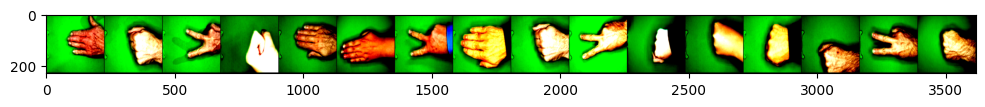

In [204]:
plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [205]:
inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                    std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

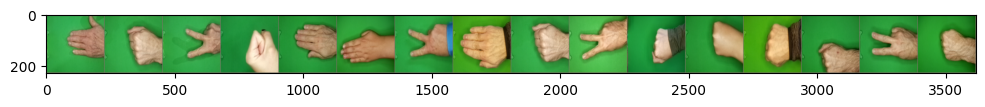

In [206]:
plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [207]:
sample_image = next(iter(train_loader))[0][0]  # Get the first batch, first image
input_size = sample_image.shape
print("Input size of the images:", input_size)


Input size of the images: torch.Size([3, 224, 224])


In [208]:
#model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride = 2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.fc_model = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256 * 10 * 10, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=3)
        )
    
    def forward(self,x):

        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.softmax(x, dim=1)

        return x


In [209]:
model = CNN()
model.to(DEVICE)  # Move the model to your desired device (e.g., 'cuda' or 'cpu')

# Define your loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [210]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate training accuracy and loss for the epoch
    train_accuracy = 100 * correct / total
    avg_train_loss = train_loss / len(train_loader)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate validation accuracy and loss for the epoch
    val_accuracy = 100 * correct / total
    avg_val_loss = val_loss / len(val_loader)
    
    # Print epoch-wise metrics
    print(f"Epoch {epoch + 1}/{EPOCHS}:")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
    print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
    
    # Append metrics to lists for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

Epoch 1/20:
Train Loss: 0.9721 | Train Acc: 62.37%
Val Loss: 0.7110 | Val Acc: 88.93%
Epoch 2/20:
Train Loss: 0.6725 | Train Acc: 89.72%
Val Loss: 0.6825 | Val Acc: 87.40%
Epoch 3/20:
Train Loss: 0.6162 | Train Acc: 94.22%
Val Loss: 0.6251 | Val Acc: 93.13%
Epoch 4/20:
Train Loss: 0.6038 | Train Acc: 94.89%
Val Loss: 0.6014 | Val Acc: 96.56%
Epoch 5/20:
Train Loss: 0.5878 | Train Acc: 97.18%
Val Loss: 0.6020 | Val Acc: 96.18%
Epoch 6/20:
Train Loss: 0.5815 | Train Acc: 97.58%
Val Loss: 0.5979 | Val Acc: 95.80%
Epoch 7/20:
Train Loss: 0.5786 | Train Acc: 97.92%
Val Loss: 0.5909 | Val Acc: 96.18%
Epoch 8/20:
Train Loss: 0.5735 | Train Acc: 98.25%
Val Loss: 0.5976 | Val Acc: 95.80%
Epoch 9/20:
Train Loss: 0.5725 | Train Acc: 98.32%
Val Loss: 0.6002 | Val Acc: 95.42%
Epoch 10/20:
Train Loss: 0.5720 | Train Acc: 98.05%
Val Loss: 0.5805 | Val Acc: 97.33%
Epoch 11/20:
Train Loss: 0.5677 | Train Acc: 98.66%
Val Loss: 0.5841 | Val Acc: 96.95%
Epoch 12/20:
Train Loss: 0.5645 | Train Acc: 99.06%


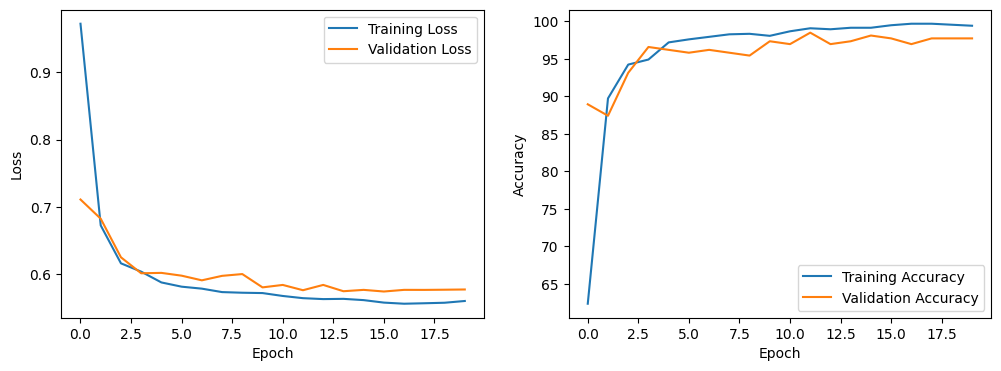

In [211]:
#plotting loss and accuracy vs epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [212]:
#testing the model
model.eval()
test_loss = 0.0
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():

    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true += labels.tolist()
        y_pred += predicted.tolist()

    # Calculate test accuracy and loss
    test_accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader)

    print(f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_accuracy:.2f}%")

Test Loss: 0.5660 | Test Acc: 98.40%


In [213]:
print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

              precision    recall  f1-score   support

       paper     0.9792    0.9860    0.9826       143
        rock     0.9931    0.9931    0.9931       145
    scissors     0.9799    0.9733    0.9766       150

    accuracy                         0.9840       438
   macro avg     0.9840    0.9842    0.9841       438
weighted avg     0.9840    0.9840    0.9840       438



In [214]:
# ensuring that the model weight names are apparopriate so that they can be loaded and used in the next notebook

# Load the state_dict with custom mapping
state_dict = model.state_dict()

# Rename keys in state_dict using the custom mapping
new_state_dict = {}
for key, value in state_dict.items():
        new_key = "baseModel." + key
        new_state_dict[new_key] = value

del new_state_dict["baseModel.fc_model.5.weight"]
del new_state_dict["baseModel.fc_model.5.bias"]

new_state_dict["regressor.0.weight"] = torch.randn((128, 1024))*0.01
new_state_dict["regressor.0.bias"] = torch.randn((128))*0.01
new_state_dict["regressor.2.weight"] = torch.randn((64,128))*0.01
new_state_dict["regressor.2.bias"] = torch.randn((64))*0.01
new_state_dict["regressor.4.weight"] = torch.randn((32,64))*0.01
new_state_dict["regressor.4.bias"] = torch.randn((32))*0.01
new_state_dict["regressor.6.weight"] = torch.randn((4,32))*0.01
new_state_dict["regressor.6.bias"] = torch.randn((4))*0.01
new_state_dict["classifier.0.weight"] = torch.randn((512,1024))*0.01
new_state_dict["classifier.0.bias"] = torch.randn((512))*0.01
new_state_dict["classifier.3.weight"] = torch.randn((512,512))*0.01
new_state_dict["classifier.3.bias"] = torch.randn((512))*0.01
new_state_dict["classifier.6.weight"] = torch.randn((4,512))*0.01
new_state_dict["classifier.6.bias"] = torch.randn((4))*0.01


In [215]:
#saving the model weights
torch.save(new_state_dict, 'model_weights.pth')

In [217]:
new_state_dict

{'baseModel.cnn_model.0.weight': tensor([[[[-9.6999e-02,  1.2756e-01,  1.9288e-01],
           [-1.3060e-01, -1.1162e-01, -1.8922e-01],
           [-3.2896e-02, -1.7350e-01, -6.3867e-02]],
 
          [[ 5.9771e-02,  1.3756e-01,  1.0888e-01],
           [ 1.0823e-01,  8.1386e-02, -1.1770e-01],
           [-1.5130e-01,  9.5441e-03,  1.8432e-01]],
 
          [[ 1.2365e-02, -1.4942e-02, -1.2896e-01],
           [-9.3987e-02, -1.4691e-01,  1.5552e-01],
           [-2.9848e-02, -1.6860e-01,  2.1873e-02]]],
 
 
         [[[ 1.1915e-02, -2.5716e-02,  6.6876e-02],
           [ 1.0101e-01, -1.8338e-01, -1.4998e-01],
           [-1.1905e-02, -1.8104e-01, -1.7761e-01]],
 
          [[ 1.7183e-01, -1.2493e-02, -9.2832e-02],
           [-6.3905e-02, -1.4791e-01,  1.5268e-01],
           [-3.9584e-02, -1.0581e-01, -1.4341e-01]],
 
          [[ 1.1142e-01, -2.7517e-02, -2.1110e-02],
           [-5.1122e-02, -9.3712e-02,  3.3407e-02],
           [ 1.4708e-01, -1.1238e-01,  8.3437e-03]]],
 
 
        